# Sarcasm Detection
 **Acknowledgement**

Misra, Rishabh, and Prahal Arora. "Sarcasm Detection using Hybrid Neural Network." arXiv preprint arXiv:1908.07414 (2019).

**Required Files given in below link.**

https://drive.google.com/drive/folders/1xUnF35naPGU63xwRDVGc-DkZ3M8V5mMk

# Description:
Past studies in Sarcasm Detection mostly make use of Twitter datasets collected using hashtag based
supervision but such datasets are noisy in terms of labels and language. Furthermore, many tweets are
replies to other tweets and detecting sarcasm in these requires the availability of contextual tweets.
In this hands-on project, the goal is to build a model to detect whether a sentence is sarcastic or not, using
Bidirectional LSTMs.
# Dataset:
News Headlines dataset for Sarcasm Detection
The dataset is collected from two news websites, theonion.com and huffingtonpost.com
This new dataset has the following advantages over the existing Twitter datasets:
Since news headlines are written by professionals in a formal manner, there are no spelling mistakes and
informal usage. This reduces the sparsity and also increases the chance of finding pre-trained embeddings.
Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with
much less noise as compared to Twitter datasets.
Unlike tweets that reply to other tweets, the news headlines obtained are self-contained. This would help us in
teasing apart the real sarcastic elements
# Content:
Each record consists of three attributes:
- is_sarcastic: 1 if the record is sarcastic otherwise 0
- headline: the headline of the news article
- article_link: link to the original news article. Useful in collecting supplementary data

## Install `Tensorflow2.0` 

In [2]:
#!!pip uninstall tensorflow
#!pip install tensorflow==2.0.0

In [3]:
#!pip install tensorflow-gpu

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from bs4 import BeautifulSoup
import re
import string
from string import punctuation
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split


import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.2.0


## Get Required Files from Drive

In [3]:
from google.colab import drive
drive.mount('/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive/


In [4]:
#Set your project path 
project_path =  "/gdrive/My Drive/Colab Notebooks/Sequential NLP-Project/Sarcasm Detection/Data/"

#**## Reading and Exploring Data**

## Read Data "Sarcasm_Headlines_Dataset.json". Explore the data and get  some insights about the data. ( 4 marks)
Hint - As its in json format you need to use pandas.read_json function. Give paraemeter lines = True.

In [5]:
sarcasm_df = pd.read_json(project_path + "Sarcasm_Headlines_Dataset.json", lines=True)

In [6]:
sarcasm_df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


#### Check for any missing value

In [7]:
sarcasm_df.isna().sum()

article_link    0
headline        0
is_sarcastic    0
dtype: int64

#### Check data imbalance or not

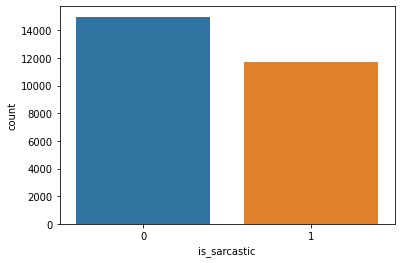

In [8]:
sns.countplot(sarcasm_df["is_sarcastic"])

In [9]:
#import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**Remove stop words from headline. Also tried to build model without removing stopwords in that case accuracy is around 45 %. Hence applied preprocessing removed stopwords and punctuation.**

In [10]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [11]:
def remove_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)


#Removing the noisy text
def pre_process_headline(text):
    text = remove_html(text)
    text = remove_square_brackets(text)
    text = remove_stopwords(text)
    return text

In [12]:
sarcasm_df['headline'] = sarcasm_df['headline'].apply(pre_process_headline)

In [13]:
sarcasm_df['headline']

0        former versace store clerk sues secret 'black ...
1        'roseanne' revival catches thorny political mo...
2        mom starting fear son's web series closest thi...
3        boehner wants wife listen, come alternative de...
4        j.k. rowling wishes snape happy birthday magic...
                               ...                        
26704                    american politics moral free-fall
26705                              america's best 20 hikes
26706                                    reparations obama
26707    israeli ban targeting boycott supporters raise...
26708                            gourmet gifts foodie 2014
Name: headline, Length: 26709, dtype: object

**Number of characters in texts for sarcastic and non sarcastic headline**

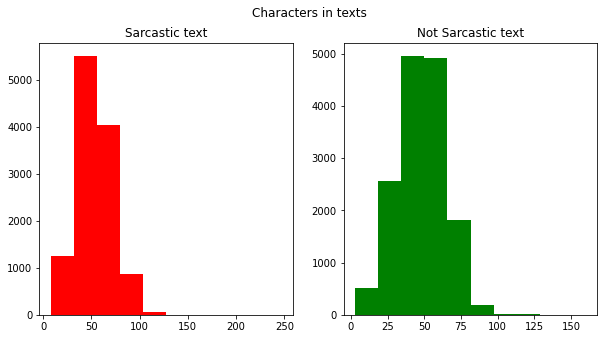

In [14]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=sarcasm_df[sarcasm_df['is_sarcastic']==1]['headline'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')

text_len=sarcasm_df[sarcasm_df['is_sarcastic']==0]['headline'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Characters in texts')
plt.show()

**Number of words in each sarcastic and non sarcastic text**

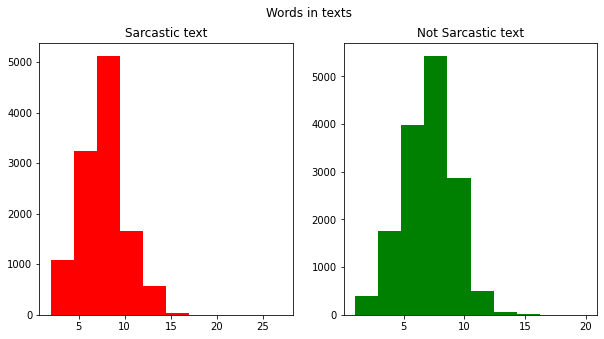

In [15]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=sarcasm_df[sarcasm_df['is_sarcastic']==1]['headline'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')

text_len=sarcasm_df[sarcasm_df['is_sarcastic']==0]['headline'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Words in texts')
plt.show()

## Drop `article_link` from dataset. ( 2 marks)
As we only need headline text data and is_sarcastic column for this project. We can drop artical link column here.

In [16]:
sarcasm_df.drop(labels=["article_link"], axis=1, inplace=True)
sarcasm_df.head()

,headline,is_sarcastic
0,former versace store clerk sues secret 'black ...,0
1,'roseanne' revival catches thorny political mo...,0
2,mom starting fear son's web series closest thi...,1
3,"boehner wants wife listen, come alternative de...",1
4,j.k. rowling wishes snape happy birthday magic...,0


## Get the Length of each line and find the maximum length. ( 4 marks)
As different lines are of different length. We need to pad the our sequences using the max length.

In [17]:
#Find length of each headline
sarcasm_df["headline_len"] = sarcasm_df["headline"].apply(lambda x: len(x))

**Note: Here I am calculating max and min lenght after applying preprocessing, due to which min length is changes to 3. If preprocessing is not applied min lenght will be equal to 7.**

In [18]:
max_lenght = sarcasm_df["headline_len"].max()
print("Max lenght: ",max_lenght)
sarcasm_df.loc[sarcasm_df["headline_len"].idxmax(axis=1), ["headline"]]["headline"]

Max lenght:  247


'maya angelou, poet, author, civil rights activist, and—holy cow—tony award–nominated actress, college professor, magazine editor, streetcar conductor—really? streetcar conductor? wow—calypso singer, nightclub performer, foreign journalist, dead 86'

In [19]:
min_lenght = sarcasm_df["headline_len"].min()
print("Max lenght: ",min_lenght)
sarcasm_df.loc[sarcasm_df["headline_len"].idxmin(axis=1), ["headline"]]["headline"]

Max lenght:  3


'men'

**Average word lenght in sarcastic and non sarcastic headline**

Text(0.5, 0.98, 'Average word length in each text')

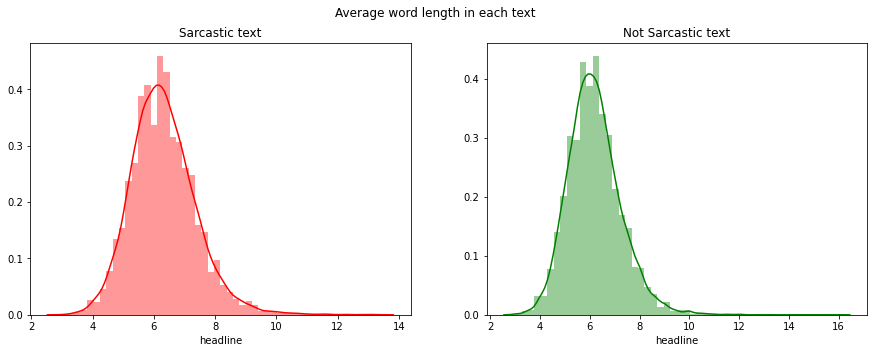

In [20]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
word=sarcasm_df[sarcasm_df['is_sarcastic']==1]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Sarcastic text')

word=sarcasm_df[sarcasm_df['is_sarcastic']==0]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Average word length in each text')

**Word cloud for text that is not sarcastic(Label:0)**

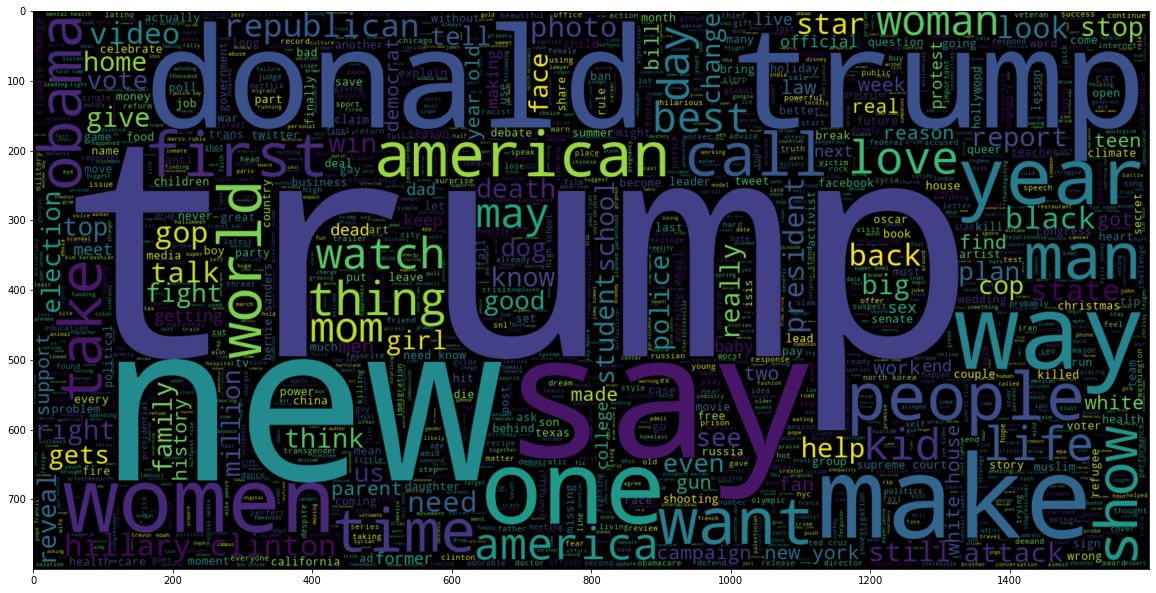

In [21]:
plt.figure(figsize = (20,20)) # Text that is Not Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(sarcasm_df[sarcasm_df.is_sarcastic == 0].headline))
plt.imshow(wc , interpolation = 'bilinear')

**Word cloud for text that is sarcastic(Label:1)**

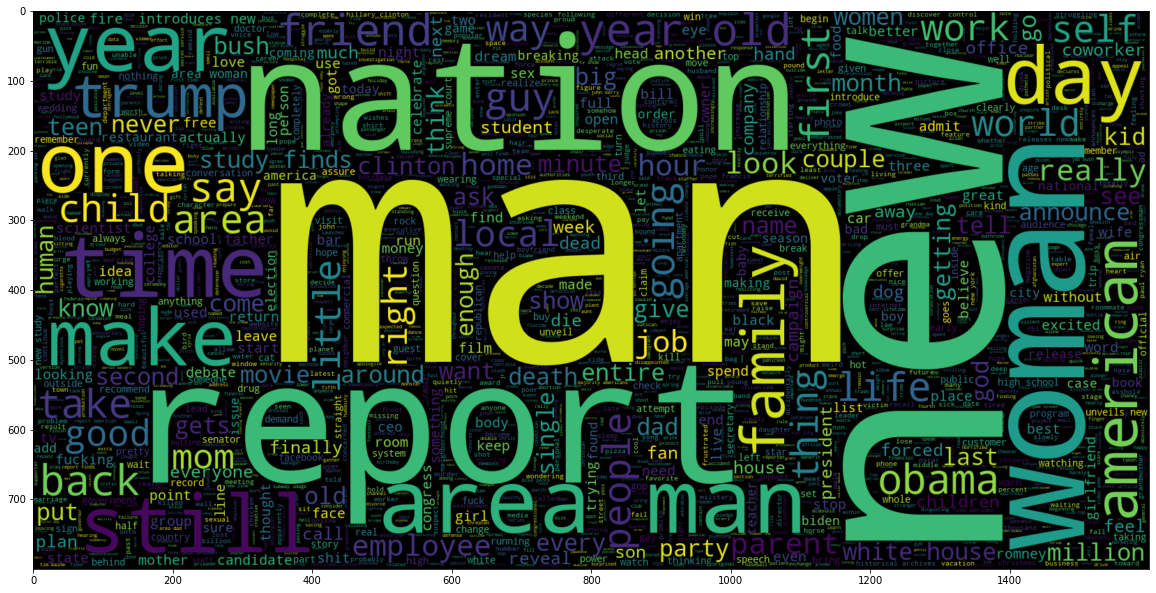

In [22]:
plt.figure(figsize = (20,20)) # Text that is Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(sarcasm_df[sarcasm_df.is_sarcastic == 1].headline))
plt.imshow(wc , interpolation = 'bilinear')

#**Modelling**

## Import required modules required for modelling.

In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential


# Set Different Parameters for the model. ( 2 marks)

In [24]:
max_features = 10000
maxlen = 200 # Setting max len
embedding_size = 200

**Convert "headline" in list acceptable format by gensim**

In [25]:
words = []
for i in sarcasm_df["headline"].values:
    l = []
    for j in i.split():
        l.extend(i.split())
        break
    words.append(l)

In [26]:
print(words[2])

['mom', 'starting', 'fear', "son's", 'web', 'series', 'closest', 'thing', 'grandchild']


In [27]:
import gensim

#Dimension of vectors we are generating
EMBEDDING_DIM = 200

#Create vector of words using Word2Vec
w2v_model = gensim.models.Word2Vec(sentences = words , size=EMBEDDING_DIM , window = 5 , min_count = 1)

In [28]:
#Word2vec model
print(w2v_model)

Word2Vec(vocab=36430, size=200, alpha=0.025)


In [29]:
vocab_size = len(w2v_model.wv.vocab)
print("vocab_size: ",vocab_size)

vocab_size:  36430


## Apply Keras Tokenizer of headline column of your data.  ( 4 marks)
Hint - First create a tokenizer instance using Tokenizer(num_words=max_features) 
And then fit this tokenizer instance on your data column df['headline'] using .fit_on_texts()

**Note: I tried to apply tokenization with num_words = 10000, and in this case accuracy was less. Then I tried with different number of words. With num_words=35000 I am getting better accuracy.**

In [30]:
## Word Tokenizer
word_tokenizer = Tokenizer(num_words=35000)
word_tokenizer.fit_on_texts(words)
tokenized_train = word_tokenizer.texts_to_sequences(words)
x_feature = tf.keras.preprocessing.sequence.pad_sequences(tokenized_train, maxlen = maxlen)

In [31]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(word_tokenizer.word_index) + 1
print("vocab_size: ",vocab_size)

vocab_size:  36431


# Define X and y for your model.

In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(x_feature, sarcasm_df["is_sarcastic"], test_size = 0.2 , random_state = 42)

In [33]:
print("X_train shape: ", X_train.shape, Y_train.shape)
print("X_test shape: ", X_test.shape, Y_test.shape)

X_train shape:  (21367, 200) (21367,)
X_test shape:  (5342, 200) (5342,)


## Get the Vocabulary size ( 2 marks)
Hint : You can use tokenizer.word_index.

In [34]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(word_tokenizer.word_index) + 1
print("vocab_size: ",vocab_size)

vocab_size:  36431


### **Word Embedding**

In [35]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    
    return weight_matrix

embedding_vectors = get_weight_matrix(w2v_model, word_tokenizer.word_index)
embedding_vectors

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 6.92326784e-01, -5.48119724e-01,  1.59711123e-01, ...,
         4.26764563e-02, -3.13014463e-02, -6.88528940e-02],
       [ 5.60029089e-01, -4.54948246e-01,  1.34193763e-01, ...,
         4.46444824e-02, -3.40361968e-02, -6.94016442e-02],
       ...,
       [ 2.44613900e-03,  1.15610042e-03, -7.71870429e-04, ...,
        -5.50802739e-04, -6.25402317e-04,  2.00386602e-03],
       [-3.47670401e-04,  2.05776887e-04, -1.78545783e-03, ...,
         2.49032071e-03, -1.62780483e-03,  1.33587292e-03],
       [-1.58594328e-03, -2.49277870e-03, -1.01071212e-03, ...,
        -3.13960278e-04,  6.41164428e-04,  1.22677791e-03]])

## **Training Word2Vec Model**

In [36]:
keras.backend.clear_session()

In [37]:
#Defining Neural Network
model1 = tf.keras.Sequential()
#Non-trainable embeddidng layer
model1.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=200, trainable=True))

#LSTM 
model1.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3)))
model1.add(Dense(1, activation='sigmoid'))

#Compile model
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.01)
model1.compile(optimizer=OPTIMIZER, loss='binary_crossentropy', metrics=['accuracy'])

In [38]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 200)          7286200   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               336896    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 7,623,353
Trainable params: 7,623,353
Non-trainable params: 0
_________________________________________________________________


**Fit model word2vec model**

In [39]:
BATCH_SIZE = 128
nb_epochs = 5
r = model1.fit(x=X_train, y=Y_train, batch_size=BATCH_SIZE,  validation_data=(X_test, Y_test),  verbose=True, epochs=nb_epochs)

# Delete del embedding vector
del embedding_vectors

Epoch 1/5
167/167 [==============================] - 457s 3s/step - loss: 0.4963 - accuracy: 0.7494 - val_loss: 0.4013 - val_accuracy: 0.8182
Epoch 2/5
167/167 [==============================] - 450s 3s/step - loss: 0.1679 - accuracy: 0.9355 - val_loss: 0.4857 - val_accuracy: 0.8023
Epoch 3/5
167/167 [==============================] - 443s 3s/step - loss: 0.0395 - accuracy: 0.9851 - val_loss: 0.7150 - val_accuracy: 0.8010
Epoch 4/5
167/167 [==============================] - 451s 3s/step - loss: 0.0136 - accuracy: 0.9954 - val_loss: 0.9346 - val_accuracy: 0.8107
Epoch 5/5
167/167 [==============================] - 452s 3s/step - loss: 0.0068 - accuracy: 0.9977 - val_loss: 1.1369 - val_accuracy: 0.8063


**Training and Test accuracy**

In [40]:
#Training accuracy
trainingAcc = model1.evaluate(X_train, Y_train)
print("Training Accuracy: ", trainingAcc)

#Test accuracy
testAcc = model1.evaluate(X_test, Y_test)
print("Validation Accuracy: ", testAcc)

668/668 [==============================] - 103s 154ms/step - loss: 0.0026 - accuracy: 0.9992
Training Accuracy:  [0.0026299883611500263, 0.9991576075553894]
167/167 [==============================] - 26s 153ms/step - loss: 1.1369 - accuracy: 0.8063
Validation Accuracy:  [1.1369038820266724, 0.8062523603439331]


**Plot loss and accuracy**

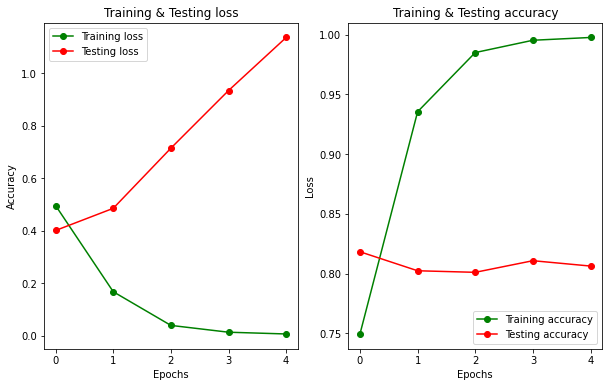

In [41]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(10,6)

#Plot training and test loss
ax[0].plot(r.history['loss'] , 'go-' , label = 'Training loss')
ax[0].plot(r.history['val_loss'] , 'ro-' , label = 'Testing loss')
ax[0].set_title('Training & Testing loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

#Plot training and test accuracy
ax[1].plot(r.history['accuracy'] , 'go-' , label = 'Training accuracy')
ax[1].plot(r.history['val_accuracy'] , 'ro-' , label = 'Testing accuracy')
ax[1].set_title('Training & Testing accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()


**Prediction**

In [42]:
Y_pred = model1.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


**Confusion matric**

In [43]:
cm = confusion_matrix(Y_test,Y_pred)
cm

array([[2489,  507],
       [ 528, 1818]])

# **Get Glove Word Embeddings**

In [46]:
x_train, x_test, y_train, y_test = train_test_split(sarcasm_df["headline"], sarcasm_df["is_sarcastic"], test_size = 0.2 , random_state = 42)

In [47]:
max_features = 35000
maxlen = 200

print("max_features: ",max_features)
print("max_features: ",maxlen)

max_features:  35000
max_features:  200


**Apply Keras Tokenizer of headline column of your data.**

**Note: I tried to apply tokenization with num_words = 10000, and in this case accuracy was less. Then I tried with different number of words. With num_words=35000 I am getting better accuracy.**

In [48]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train_glove = tf.keras.preprocessing.sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [49]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
x_test_glove = tf.keras.preprocessing.sequence.pad_sequences(tokenized_test, maxlen=maxlen)

**Get Glove embedding file**

In [50]:
glove_file = project_path + "glove.6B.zip"
glove_file

'/gdrive/My Drive/Colab Notebooks/Sequential NLP-Project/Sarcasm Detection/Data/glove.6B.zip'

In [51]:
#Extract Glove embedding zip file
from zipfile import ZipFile
with ZipFile(glove_file, 'r') as z:
  z.extractall()

In [52]:
!ls

glove.6B.100d.txt  glove.6B.300d.txt  sample_data
glove.6B.200d.txt  glove.6B.50d.txt


# Get the Word Embeddings using Embedding file as given below.

In [53]:
EMBEDDING_FILE  = './glove.6B.50d.txt'
#EMBEDDING_FILE  = './glove.6B.100d.txt'
#EMBEDDING_FILE  = './glove.6B.200d.txt'
#EMBEDDING_FILE  = './glove.6B.300d.txt'

'''
embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd
'''

def get_word_embeddings(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_word_embeddings(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

# Create a weight matrix for words in training docs

In [54]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index)+1)

#embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


In [55]:
print("Embedding size: ", embed_size)

Embedding size:  50


## Create and Compile your Model  ( 7 marks)
Hint - Use Sequential model instance and then add Embedding layer, Bidirectional(LSTM) layer, then dense and dropout layers as required. 
In the end add a final dense layer with sigmoid activation for binary classification.


In [57]:
keras.backend.clear_session()

In [58]:
#Model2
model2 = tf.keras.Sequential()
### Embedding layer
model2.add(Embedding(nb_words, output_dim=embed_size, weights=[embedding_matrix], input_length=200, trainable=True))

#Bidirectional LSTM 
model2.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.2)))
model2.add(Dense(1, activation='sigmoid'))

#Compile model
OPT = tf.keras.optimizers.Adam(learning_rate=0.01)
model2.compile(optimizer=OPT, loss='binary_crossentropy', metrics=['accuracy'])

In [59]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 50)           1323250   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               183296    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 1,506,803
Trainable params: 1,506,803
Non-trainable params: 0
_________________________________________________________________


# Fit your model with a batch size of 100 and validation_split = 0.2. and state the validation accuracy ( 5 marks)


In [60]:
BATCH_SIZE = 100
nb_epochs = 5

**Fit Glove embedding model**

In [61]:
r = model2.fit(x=x_train_glove, y=y_train, batch_size=BATCH_SIZE,  validation_data=(x_test_glove, y_test),  verbose=True, epochs=nb_epochs)

Epoch 1/5
214/214 [==============================] - 565s 3s/step - loss: 0.4904 - accuracy: 0.7606 - val_loss: 0.3948 - val_accuracy: 0.8210
Epoch 2/5
214/214 [==============================] - 562s 3s/step - loss: 0.2186 - accuracy: 0.9109 - val_loss: 0.4059 - val_accuracy: 0.8261
Epoch 3/5
214/214 [==============================] - 566s 3s/step - loss: 0.0821 - accuracy: 0.9684 - val_loss: 0.6204 - val_accuracy: 0.8192
Epoch 4/5
214/214 [==============================] - 565s 3s/step - loss: 0.0363 - accuracy: 0.9864 - val_loss: 0.8177 - val_accuracy: 0.8087
Epoch 5/5
214/214 [==============================] - 565s 3s/step - loss: 0.0207 - accuracy: 0.9931 - val_loss: 0.9074 - val_accuracy: 0.8119


### Training and Test accuracy

In [62]:
#Training accuracy
trainingAcc = model2.evaluate(x_train_glove, y_train)
print("Training Accuracy: ", trainingAcc)

#Test accuracy
testAcc = model2.evaluate(x_test_glove, y_test)
print("Validation Accuracy: ", testAcc)

668/668 [==============================] - 89s 133ms/step - loss: 0.0068 - accuracy: 0.9981
Training Accuracy:  [0.006771079730242491, 0.9980811476707458]
167/167 [==============================] - 22s 132ms/step - loss: 0.9074 - accuracy: 0.8119
Validation Accuracy:  [0.9073573350906372, 0.8118681907653809]


**Plot Loss and Accuracy**

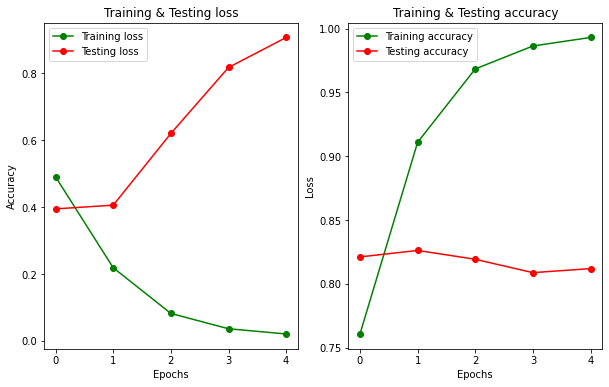

In [63]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(10,6)

#Plot training and test loss
ax[0].plot(r.history['loss'] , 'go-' , label = 'Training loss')
ax[0].plot(r.history['val_loss'] , 'ro-' , label = 'Testing loss')
ax[0].set_title('Training & Testing loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

#Plot training and test accuracy
ax[1].plot(r.history['accuracy'] , 'go-' , label = 'Training accuracy')
ax[1].plot(r.history['val_accuracy'] , 'ro-' , label = 'Testing accuracy')
ax[1].set_title('Training & Testing accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

**Prediction**

In [64]:
y_pred_glove = model2.predict_classes(x_test_glove)

**Confusion matrix**

In [65]:
cm_g = confusion_matrix(y_test, y_pred_glove)
cm_g

array([[2652,  344],
       [ 661, 1685]])

# **Conclusion:**
**1. In this solution I have build 2 models. First one (that is model1)is word2vec model. Used gensim word2vec to learn word embeddings, having embedding size = 200. After this build Bidirectional LSTM model and test accuracy of this word2vec model is around:80.25%**

**2. In 2nd one (that is model2) used Glove word embedding and then build Bidirectional LSTM model. In this expriment I used different embedding size to build Bidirectional LSTM. Test accuracy of all embedding size is around 80 %.**

> Embedding size: 50d, Accuracy: 82.51 %


> Embedding size: 100d, Accuracy: 80.83 %


> Embedding size: 200d, Accuracy: 81.28 %


> Embedding size: 300d, Accuracy: 80.55 %

**3. Embedding size: 50 gives best accuracy**

**4. Here I am calculating max and min lenght after applying preprocessing, due to which min length is changes to 3. If preprocessing is not applied min lenght will be equal to 7**

**5. I tried to apply tokenization with num_words = 10000, and in this case accuracy was less. Then I tried with different number of words. With num_words=35000 I am getting better accuracy**

**6. Also tried different optimizer, Adam is giving best accuracy.**